In [2]:
import pickle

with open('promo_numeric_pickle.pkl','rb') as pkl:
    df = pickle.load(pkl)

In [32]:
# dtypes are preserved
df.dtypes

chainid                                 int64
subchainid                              int64
storeid                                 int64
bikoretno                               int64
itemcode                                int64
isgiftitem                              int64
rewardtype                              int64
allowmultiplediscounts                  int64
promotionid                             int64
discountrate                          float64
discounttype                            int64
minqty                                float64
weightunit                              int64
minnoofitemofered                       int64
isweightedpromo                         int64
discountedpricepermida                float64
discountedprice                       float64
minpurchaseamnt                         int64
maxqty                                float64
clubid                                  int64
additionalsgiftcount                  float64
minpurchaseamount                 

In [33]:
ignore_columns = ['chainid','subchainid','storeid','bikoretno','promotionid','itemcode']
categorial_feature = 'discounttype'
chain = 7290027600007

def zoom_to_sub_frame(df,chain):
    return df[(df.chainid == chain)]
    
chain_df = zoom_to_sub_frame(df,chain)

def get_minimal_change_in_catagory(chain_df,categorial_feature):
    mean_across_cat = chain_df.groupby(categorial_feature).mean()
    no_change = []
    for column in mean_across_cat.columns:
        if len(mean_across_cat[column].unique()) == 1:
            no_change.append(column)

    return mean_across_cat.drop(columns=no_change+ignore_columns)

mean_across_cat = get_minimal_change_in_catagory(chain_df,categorial_feature)
mean_across_cat


,rewardtype,discountrate,minqty,isweightedpromo,promotiondescription_len,promotiondescription_all_digits,promotiondescription_digits_groups,promotiondescription_preceage,promotionitems_len,clubs_len
discounttype,,,,,,,,,,
-1,6.611730,-1.000000,2.447094,0.041277,31.506162,5.702895,2.771047,0.034892,5.158278,1.034595
0,3.774286,5367.142857,1.322862,0.005143,31.258857,4.813714,1.734857,0.905714,80.180571,1.021143
1,8.448980,8.275510,1.908163,0.000000,29.193878,2.132653,1.214286,0.030612,10.020408,1.000000


In [34]:
def normalized_change_across_categories(chain_df,mean_across_cat):
    max_across_cat = chain_df.max()
    min_across_cat = chain_df.min()
    
    return (mean_across_cat -  min_across_cat) / (max_across_cat - min_across_cat)


def noramlized_max_change_across_categories(chain_df,mean_across_cat):
    noramlized_cat = normalized_change_across_categories(chain_df[mean_across_cat.columns],mean_across_cat)
    return noramlized_cat.max() - noramlized_cat.min()

noramlized_max_std = noramlized_max_change_across_categories(chain_df,mean_across_cat)
noramlized_max_std

rewardtype                            0.519410
discountrate                          0.536761
minqty                                0.013879
isweightedpromo                       0.041277
promotiondescription_len              0.082582
promotiondescription_all_digits       0.223140
promotiondescription_digits_groups    0.259460
promotiondescription_preceage         0.291701
promotionitems_len                    0.009743
clubs_len                             0.034595
dtype: float64

In [35]:
def noramlized_std_across_categories(chain_df,mean_across_cat):
    std_across_cat = chain_df[mean_across_cat.columns].std()
    return normalized_change_across_categories(chain_df[mean_across_cat.columns],std_across_cat)

noramlized_std_cat = noramlized_std_across_categories(chain_df,mean_across_cat)
noramlized_std_cat

rewardtype                            0.357041
discountrate                          0.245943
minqty                                0.061675
isweightedpromo                       0.179788
promotiondescription_len             -0.236555
promotiondescription_all_digits       0.167368
promotiondescription_digits_groups    0.148800
promotiondescription_preceage         0.139255
promotionitems_len                    0.042703
clubs_len                            -0.825439
dtype: float64

In [36]:
def compound_to_columns(noramlized_max_std,noramlized_std_cat):
    return noramlized_max_std[noramlized_max_std > noramlized_std_cat]

compound_to_columns(noramlized_max_std,noramlized_std_cat)

rewardtype                            0.519410
discountrate                          0.536761
promotiondescription_len              0.082582
promotiondescription_all_digits       0.223140
promotiondescription_digits_groups    0.259460
promotiondescription_preceage         0.291701
clubs_len                             0.034595
dtype: float64

In [37]:
def complete_flow(df,chain,categorial_feature):
    chain_df = zoom_to_sub_frame(df,chain)
    mean_across_cat = get_minimal_change_in_catagory(chain_df,categorial_feature)
    noramlized_max_std = noramlized_max_change_across_categories(chain_df,mean_across_cat)
    noramlized_std_cat = noramlized_std_across_categories(chain_df,mean_across_cat)
    return compound_to_columns(noramlized_max_std,noramlized_std_cat)

complete_flow(df,chain,categorial_feature)

rewardtype                            0.519410
discountrate                          0.536761
promotiondescription_len              0.082582
promotiondescription_all_digits       0.223140
promotiondescription_digits_groups    0.259460
promotiondescription_preceage         0.291701
clubs_len                             0.034595
dtype: float64

In [38]:
# find semi-categorial

columns_with_affect = set()
for col in df.columns:
    
    if col not in ignore_columns:
        print(f" ----{col}---- ")
        feature_affected = complete_flow(df,chain,col)
        if feature_affected.empty:
            print("No effect")
        else:
            print(feature_affected)
            columns_with_affect = columns_with_affect.union(set(feature_affected.index))
            
columns_with_affect

 ----isgiftitem---- 
No effect
 ----rewardtype---- 
discountrate                          1.000000
discounttype                          1.000000
promotiondescription_len              0.280536
promotiondescription_all_digits       0.302177
promotiondescription_digits_groups    0.322330
promotiondescription_preceage         0.333333
clubs_len                             0.082528
dtype: float64
 ----allowmultiplediscounts---- 
No effect
 ----discountrate---- 
rewardtype                            0.777778
discounttype                          0.986958
promotiondescription_len              0.357143
promotiondescription_all_digits       0.837114
promotiondescription_digits_groups    0.333333
promotiondescription_preceage         0.335749
promotionitems_len                    0.835393
clubs_len                             0.065868
dtype: float64
 ----discounttype---- 
rewardtype                            0.519410
discountrate                          0.536761
promotiondescription_len      

{'clubs_len',
 'discountrate',
 'discounttype',
 'isweightedpromo',
 'minqty',
 'promotiondescription_all_digits',
 'promotiondescription_digits_groups',
 'promotiondescription_len',
 'promotiondescription_preceage',
 'promotionitems_len',
 'rewardtype'}

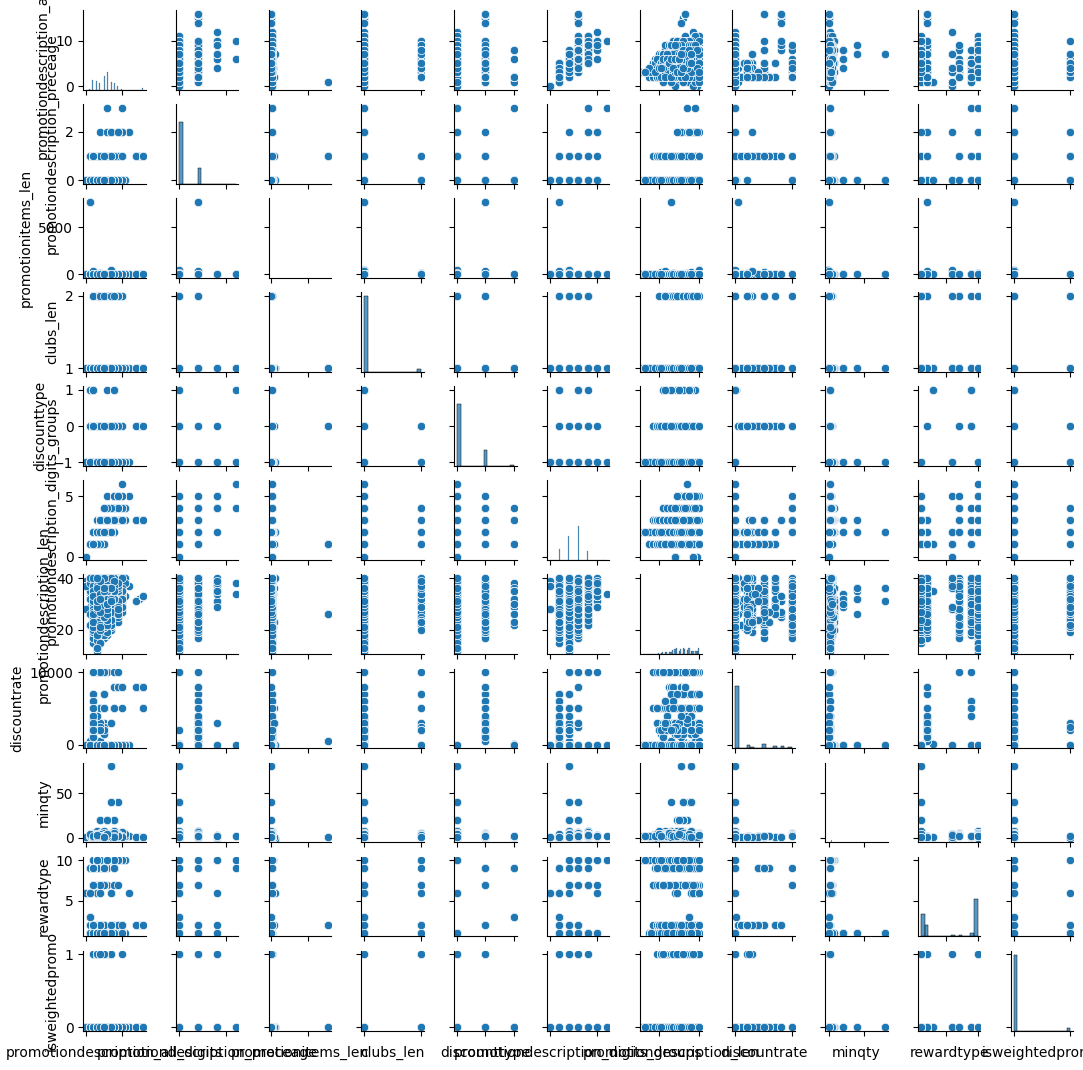

In [39]:
import seaborn as sns


g = sns.pairplot(data=df[df["chainid"] == chain], vars=list(columns_with_affect), size=1.)
g.set(xticklabels=[])

# Check which field are ignored by Chain

In [40]:
ignore_columns_with_chain = ignore_columns.copy()
ignore_columns_with_chain.remove('chainid')

usage_across = df.drop(columns=ignore_columns_with_chain).groupby('chainid').nunique()
usage_across

,isgiftitem,rewardtype,allowmultiplediscounts,discountrate,discounttype,minqty,weightunit,minnoofitemofered,isweightedpromo,discountedpricepermida,...,remark_digits_groups,remark_preceage,additionalsminbasketamount_len,additionalscoupon_len,additionalstotals_len,promotionitems_len,clubs_len,promotiondetails_len,additionalrestrictions_len,giftsitems_len
chainid,,,,,,,,,,,,,,,,,,,,,
7290027600007,1,7,1,15,3,22,1,1,2,1,...,1,1,1,1,1,77,2,1,1,1
7290055700014,1,5,2,1,1,16,2,1,2,398,...,1,1,1,1,1,53,2,1,1,1
7290058108879,1,3,1,3,2,11,1,1,1,162,...,1,1,1,1,1,29,1,1,1,1
7290058134977,1,4,1,2,2,12,1,1,1,115,...,1,1,1,1,1,25,1,1,1,1
7290058140886,1,6,2,1,1,21,2,1,2,310,...,1,1,1,1,1,77,3,1,1,1
7290058159628,1,3,1,3,2,10,1,1,1,100,...,1,1,1,1,1,31,1,1,1,10
7290058160839,1,3,1,5,2,11,1,1,1,105,...,1,1,1,1,1,36,1,1,1,1
7290058173198,1,3,1,3,2,11,1,1,1,117,...,1,1,1,1,1,42,1,1,1,1
7290058197699,1,3,1,5,2,5,1,1,1,67,...,1,1,1,1,1,28,1,1,1,1


In [41]:
# columns not in use
usage_across.loc[:,usage_across.nunique() == 1].columns

Index(['minnoofitemofered', 'minnoofitemsoffered', 'file_id_all_digits',
       'file_id_digits_groups', 'file_id_preceage', 'remark_len',
       'remark_all_digits', 'remark_digits_groups', 'remark_preceage',
       'additionalsminbasketamount_len', 'additionalscoupon_len',
       'additionalstotals_len', 'promotiondetails_len',
       'additionalrestrictions_len'],
      dtype='object')

In [42]:
(usage_across > 1).sum() / (usage_across > 1).count()
# there is no single column that is used across all chain!

isgiftitem                            0.115385
rewardtype                            0.961538
allowmultiplediscounts                0.384615
discountrate                          0.384615
discounttype                          0.384615
minqty                                0.961538
weightunit                            0.500000
minnoofitemofered                     0.000000
isweightedpromo                       0.576923
discountedpricepermida                0.884615
discountedprice                       0.923077
minpurchaseamnt                       0.153846
maxqty                                0.346154
clubid                                0.038462
additionalsgiftcount                  0.076923
minpurchaseamount                     0.076923
minnoofitemsoffered                   0.000000
itemtype                              0.076923
file_id_len                           0.038462
file_id_all_digits                    0.000000
file_id_digits_groups                 0.000000
file_id_prece

 # Trying to find matching cloumns

In [1]:
import pickle
with open('promo_pickle.pkl','rb') as pkl:
    df1 = pickle.load(pkl)
    
with open('promo_type_pickle.pkl','rb') as pkl:
    typing_dict = pickle.load(pkl)

ignore_columns = ['chainid','subchainid','storeid','bikoretno','promotionid','itemcode']

In [2]:
typing_dict

{'json_parse': ['additionalsminbasketamount',
  'additionalscoupon',
  'additionalstotals',
  'promotionitems',
  'clubs',
  'promotiondetails',
  'additionalrestrictions',
  'giftsitems'],
 'boolean_parse': ['isgiftitem', 'allowmultiplediscounts', 'isweightedpromo'],
 'num_parse': ['minnoofitemsoffered',
  'itemtype',
  'minpurchaseamnt',
  'chainid',
  'subchainid',
  'storeid',
  'bikoretno',
  'minnoofitemofered',
  'itemcode',
  'rewardtype',
  'promotionid',
  'discounttype',
  'weightunit',
  'clubid'],
 'floats_parse': ['minpurchaseamount',
  'discountedprice',
  'discountedpricepermida',
  'discountrate',
  'maxqty',
  'minqty',
  'additionalsgiftcount'],
 'time_parse': [],
 'date_parse': ['priceupdatedate',
  'promotionupdatedate',
  'promotionstartdatetime',
  'promotionenddatetime'],
 'str_prase': ['file_id', 'promotiondescription', 'remarks', 'remark']}

In [3]:
df1 = df1.drop(columns=typing_dict['date_parse'])

In [4]:
def json_to_string(x):
    return str(x).replace("[]","EMPTYLIST").replace("{}","EMPTYDICT")

for col in typing_dict['json_parse']:
    df1[col] = df1[col].apply(json_to_string)

In [5]:
for col in typing_dict['str_prase']:
    df1[col] = df1[col].replace("","EMPTY")

In [6]:
# ! pip install schema-matching 
from schema_utils import match_two_dataframe

schema_matching|Loading sentence transformer, this will take a while...
schema_matching|Done loading sentence transformer


In [46]:
def create_permutations(list_a):
    import itertools
    import numpy as np
    
    permutations = list()
    
    for i in range(len(list_a)):
        add = 0
        for j in range(i+1,len(list_a)):
            add+=1
            permutations.append((list_a[i],list_a[j]))
        #print(add)
    return permutations#, list(map(lambda x: set(x), permutations))

unique_chains = list(df1.chainid.unique())
comb = create_permutations(unique_chains)

In [47]:
import pandas as pd


unique_chains.remove(first_chain)

matchs = []
for first_chain,second_chain in comb:

    first_df = df1[df1.chainid == first_chain].drop(columns=ignore_columns)
    second_df = df1[df1.chainid == second_chain].drop(columns=ignore_columns)
    second_df.columns = map(str,range(len(second_df.columns)))

    df_pred,df_pred_labels,predicted_pairs = match_two_dataframe(first_df,second_df)
    
    
    diagonal_scores = pd.Series(df_pred.values.diagonal(),first_df.columns)
    
    
    print(f" ----{second_chain}---- ")
    print(diagonal_scores[diagonal_scores < 0.9])
    matchs.append(diagonal_scores) # 7290696200003

 ----7290058140886---- 
isgiftitem                0.031994
rewardtype                0.781936
promotiondetails          0.000078
additionalrestrictions    0.000063
clubs                     0.000160
minqty                    0.004357
promotiondescription      0.000046
weightunit                0.010461
minnoofitemofered         0.227210
isweightedpromo           0.030822
promotionitems            0.000060
discountedpricepermida    0.057586
discountedprice           0.053915
dtype: float32
 ----7291059100008---- 
file_id                       0.863144
isgiftitem                    0.012258
rewardtype                    0.623559
allowmultiplediscounts        0.859317
promotiondetails              0.000077
additionalrestrictions        0.002650
clubs                         0.006907
discountrate                  0.826129
discounttype                  0.871439
minqty                        0.004264
promotiondescription          0.000064
weightunit                    0.005858
minnoofitemofe

 ----7290058108879---- 
file_id                       0.867543
isgiftitem                    0.012126
rewardtype                    0.621160
allowmultiplediscounts        0.133590
promotiondetails              0.000077
additionalrestrictions        0.002656
clubs                         0.893533
discountrate                  0.001837
discounttype                  0.008378
minqty                        0.003882
promotiondescription          0.000064
weightunit                    0.892758
minnoofitemofered             0.129651
promotionitems                0.000059
discountedpricepermida        0.029777
discountedprice               0.022878
minpurchaseamnt               0.127572
maxqty                        0.014140
remarks                       0.000096
remark                        0.882128
clubid                        0.879881
additionalsgiftcount          0.868100
additionalsminbasketamount    0.882566
minnoofitemsoffered           0.894116
itemtype                      0.887955
d

 ----7290055700014---- 
file_id                       0.746483
isgiftitem                    0.007623
rewardtype                    0.452687
allowmultiplediscounts        0.795545
promotiondetails              0.000085
additionalrestrictions        0.002430
clubs                         0.000160
discountrate                  0.708955
discounttype                  0.753471
minqty                        0.004914
promotiondescription          0.000072
weightunit                    0.005805
minnoofitemofered             0.082104
isweightedpromo               0.008172
promotionitems                0.000059
discountedpricepermida        0.046260
discountedprice               0.036477
minpurchaseamnt               0.795965
maxqty                        0.772711
remarks                       0.776794
remark                        0.768907
giftsitems                    0.810690
additionalscoupon             0.818194
clubid                        0.766849
additionalsgiftcount          0.749811
m

 ----7290027600007---- 
rewardtype                0.037564
additionalrestrictions    0.857974
discountrate              0.008560
discounttype              0.073263
minqty                    0.694194
weightunit                0.060981
isweightedpromo           0.809926
promotionitems            0.376812
discountedpricepermida    0.145533
discountedprice           0.131612
dtype: float32
 ----7290058173198---- 
allowmultiplediscounts    0.224778
additionalrestrictions    0.632838
clubs                     0.001165
discountrate              0.002252
discounttype              0.017139
minqty                    0.579638
weightunit                0.047616
isweightedpromo           0.026561
promotionitems            0.141949
minpurchaseamnt           0.007131
maxqty                    0.073784
remarks                   0.000091
dtype: float32
 ----7290725900003---- 
additionalrestrictions    0.861663
minqty                    0.408274
promotiondescription      0.653796
isweightedpromo        

 ----7290696200003---- 
file_id                   0.886901
isgiftitem                0.030655
rewardtype                0.189566
allowmultiplediscounts    0.796102
additionalrestrictions    0.000061
clubs                     0.000138
discountrate              0.022303
discounttype              0.020053
minqty                    0.352065
promotiondescription      0.686866
weightunit                0.009260
minnoofitemofered         0.226099
isweightedpromo           0.029404
promotionitems            0.000060
discountedpricepermida    0.715103
maxqty                    0.095313
remarks                   0.001737
clubid                    0.026195
additionalsgiftcount      0.012866
minpurchaseamount         0.019041
minnoofitemsoffered       0.275839
itemtype                  0.027681
dtype: float32
 ----7290644700005---- 
file_id                       0.735023
isgiftitem                    0.779833
rewardtype                    0.790900
allowmultiplediscounts        0.459189
promotionde

 ----7290058197699---- 
allowmultiplediscounts    0.212174
clubs                     0.016131
discountrate              0.001987
discounttype              0.017139
promotiondescription      0.833897
weightunit                0.047329
isweightedpromo           0.026561
promotionitems            0.642332
discountedpricepermida    0.720662
minpurchaseamnt           0.261975
maxqty                    0.073784
remarks                   0.000091
dtype: float32
 ----7290058108879---- 
file_id                       0.852912
isgiftitem                    0.892443
allowmultiplediscounts        0.114993
clubs                         0.008562
discountrate                  0.008621
discounttype                  0.016528
minqty                        0.861509
weightunit                    0.032747
minnoofitemofered             0.887996
isweightedpromo               0.024832
promotionitems                0.766096
discountedpricepermida        0.526827
discountedprice               0.494195
minpurchas

 ----7290700100008---- 
file_id                   0.858083
isgiftitem                0.899864
rewardtype                0.897529
discountrate              0.800350
discounttype              0.878860
minqty                    0.889399
promotiondescription      0.885065
weightunit                0.880646
minnoofitemofered         0.896320
isweightedpromo           0.657616
promotionitems            0.164911
discountedpricepermida    0.857657
discountedprice           0.816311
maxqty                    0.892742
clubid                    0.888763
additionalsgiftcount      0.878130
itemtype                  0.897493
dtype: float32
 ----7290785400000---- 
promotiondescription    0.014878
isweightedpromo         0.814695
dtype: float32
 ----7290873255550---- 
file_id                       0.675064
isgiftitem                    0.895455
rewardtype                    0.236304
allowmultiplediscounts        0.129773
additionalrestrictions        0.887773
clubs                         0.000452
dis

 ----7290526500006---- 
file_id                   0.885280
allowmultiplediscounts    0.132343
additionalrestrictions    0.894684
clubs                     0.011599
discountrate              0.007793
discounttype              0.018089
promotiondescription      0.578967
weightunit                0.061790
isweightedpromo           0.026837
promotionitems            0.899974
discountedpricepermida    0.826231
discountedprice           0.810488
minpurchaseamnt           0.012591
maxqty                    0.045367
remarks                   0.000091
additionalsgiftcount      0.890695
dtype: float32
 ----7290058198450---- 
file_id                 0.839219
discountrate            0.889706
minqty                  0.874602
promotiondescription    0.211384
promotionitems          0.853949
minpurchaseamnt         0.774241
remarks                 0.672750
dtype: float32
 ----7290058160839---- 
file_id                 0.865432
discountrate            0.897948
promotiondescription    0.823412
promotio

 ----7290058197699---- 
file_id                       0.787050
isgiftitem                    0.817232
rewardtype                    0.067014
allowmultiplediscounts        0.082155
promotiondetails              0.849698
additionalrestrictions        0.876753
clubs                         0.000217
discountrate                  0.001934
discounttype                  0.005350
minqty                        0.701884
promotiondescription          0.469984
weightunit                    0.822520
minnoofitemofered             0.817350
isweightedpromo               0.008494
promotionitems                0.824190
discountedpricepermida        0.046979
discountedprice               0.739854
minpurchaseamnt               0.080436
maxqty                        0.017985
remarks                       0.000091
remark                        0.806353
giftsitems                    0.843922
additionalscoupon             0.850285
clubid                        0.803704
additionalsgiftcount          0.789130
m

 ----7290696200003---- 
file_id                   0.870203
isgiftitem                0.031994
rewardtype                0.244882
allowmultiplediscounts    0.757906
additionalrestrictions    0.002474
clubs                     0.000241
discountrate              0.022311
discounttype              0.021063
promotiondescription      0.815046
minnoofitemofered         0.227210
isweightedpromo           0.030822
promotionitems            0.000059
discountedpricepermida    0.127652
discountedprice           0.869904
maxqty                    0.098400
remarks                   0.001872
clubid                    0.026891
additionalsgiftcount      0.013220
minpurchaseamount         0.018727
minnoofitemsoffered       0.289484
itemtype                  0.028934
dtype: float32
 ----7290644700005---- 
file_id                       0.740889
isgiftitem                    0.779833
rewardtype                    0.040295
allowmultiplediscounts        0.392281
promotiondetails              0.815976
additio

 ----7291056200008---- 
file_id                   0.858083
isgiftitem                0.899864
rewardtype                0.134716
allowmultiplediscounts    0.858105
clubs                     0.750278
discountrate              0.013463
discounttype              0.153668
minqty                    0.894728
promotiondescription      0.792292
weightunit                0.032654
minnoofitemofered         0.896320
promotionitems            0.238306
discountedpricepermida    0.055110
discountedprice           0.059114
maxqty                    0.892742
clubid                    0.888763
additionalsgiftcount      0.878130
itemtype                  0.897493
dtype: float32
 ----7290639000004---- 
file_id                       0.863309
isgiftitem                    0.895002
rewardtype                    0.187088
allowmultiplediscounts        0.854923
additionalrestrictions        0.835644
clubs                         0.883864
discountrate                  0.014757
discounttype                  0.18

 ----7290492000005---- 
rewardtype                0.183567
allowmultiplediscounts    0.724097
clubs                     0.757442
discountrate              0.027854
discounttype              0.227473
weightunit                0.009281
isweightedpromo           0.831861
discountedpricepermida    0.060771
discountedprice           0.023117
dtype: float32
 ----7290700100008---- 
rewardtype                0.191601
clubs                     0.833562
discountrate              0.024097
discounttype              0.212218
minqty                    0.862443
weightunit                0.029063
discountedpricepermida    0.068305
discountedprice           0.056125
additionalsgiftcount      0.899800
dtype: float32
 ----7290785400000---- 
rewardtype                0.037564
clubs                     0.223052
discountrate              0.008560
discounttype              0.073263
minqty                    0.898379
promotiondescription      0.012352
weightunit                0.067082
promotionitems         

 ----7290055700014---- 
allowmultiplediscounts    0.233848
clubs                     0.000229
discountrate              0.011391
discounttype              0.020053
promotiondescription      0.863729
weightunit                0.009184
isweightedpromo           0.029404
promotionitems            0.194332
minpurchaseamnt           0.054881
maxqty                    0.084605
remarks                   0.000105
dtype: float32
 ----7290696200003---- 
file_id                   0.792086
isgiftitem                0.012201
rewardtype                0.053273
allowmultiplediscounts    0.137926
additionalrestrictions    0.002682
discountrate              0.134010
discounttype              0.866455
minqty                    0.897435
promotiondescription      0.671422
weightunit                0.892670
minnoofitemofered         0.129554
promotionitems            0.000059
discountedpricepermida    0.498648
discountedprice           0.846299
minpurchaseamnt           0.004364
maxqty                    0

 ----7290526500006---- 
file_id                       0.857733
isgiftitem                    0.894116
allowmultiplediscounts        0.855301
clubs                         0.765114
discountrate                  0.789673
discounttype                  0.871368
minqty                        0.889843
weightunit                    0.277135
minnoofitemofered             0.889836
isweightedpromo               0.894771
promotionitems                0.142468
discountedprice               0.861160
minpurchaseamnt               0.898869
maxqty                        0.887777
remarks                       0.882895
remark                        0.879055
clubid                        0.884391
additionalsgiftcount          0.870237
additionalsminbasketamount    0.877939
minnoofitemsoffered           0.895043
itemtype                      0.892921
dtype: float32
 ----7290058198450---- 
file_id                   0.883672
rewardtype                0.882748
allowmultiplediscounts    0.147708
clubs        

 ----7290639000004---- 
file_id                   0.891069
rewardtype                0.834435
allowmultiplediscounts    0.879437
additionalrestrictions    0.824045
clubs                     0.666683
discountrate              0.822830
discounttype              0.891830
promotiondescription      0.790374
isweightedpromo           0.718519
promotionitems            0.116171
discountedprice           0.866901
additionalsgiftcount      0.890695
dtype: float32
 ----7290875100001---- 
isgiftitem                0.030398
rewardtype                0.166364
allowmultiplediscounts    0.175168
additionalrestrictions    0.002181
clubs                     0.017491
discountrate              0.008975
discounttype              0.020333
promotiondescription      0.842538
weightunit                0.011131
minnoofitemofered         0.177818
isweightedpromo           0.030257
promotionitems            0.000060
discountedpricepermida    0.543238
discountedprice           0.843835
maxqty                    0

 ----7290875100001---- 
isgiftitem                0.025999
rewardtype                0.186965
allowmultiplediscounts    0.212174
additionalrestrictions    0.000062
clubs                     0.007487
discountrate              0.009965
discounttype              0.017139
minqty                    0.808448
promotiondescription      0.781740
weightunit                0.009385
minnoofitemofered         0.214022
isweightedpromo           0.026561
promotionitems            0.000060
discountedpricepermida    0.879971
discountedprice           0.856862
maxqty                    0.073784
remarks                   0.007015
clubid                    0.234924
additionalsgiftcount      0.006923
minpurchaseamount         0.115219
minnoofitemsoffered       0.256466
itemtype                  0.023532
dtype: float32
 ----7290803800003---- 
additionalrestrictions    0.718778
discountrate              0.878775
promotiondescription      0.216228
weightunit                0.834424
isweightedpromo           0

 ----7290639000004---- 
file_id                       0.878745
allowmultiplediscounts        0.140864
additionalrestrictions        0.639970
clubs                         0.000438
discountrate                  0.001987
discounttype                  0.009287
minqty                        0.895613
promotiondescription          0.861287
weightunit                    0.043401
minnoofitemofered             0.899964
isweightedpromo               0.014492
promotionitems                0.245871
discountedpricepermida        0.562699
discountedprice               0.891831
minpurchaseamnt               0.140618
maxqty                        0.031005
remarks                       0.000091
remark                        0.893216
clubid                        0.891835
additionalsgiftcount          0.880953
additionalsminbasketamount    0.893486
itemtype                      0.899626
dtype: float32
 ----7290875100001---- 
file_id                       0.843697
isgiftitem                    0.010997
r

 ----7291056200008---- 
file_id                   0.822666
isgiftitem                0.899864
rewardtype                0.860248
allowmultiplediscounts    0.117076
clubs                     0.014805
discountrate              0.007779
discounttype              0.017526
minqty                    0.875513
promotiondescription      0.737292
weightunit                0.034959
minnoofitemofered         0.896320
isweightedpromo           0.026239
discountedpricepermida    0.498543
discountedprice           0.556460
minpurchaseamnt           0.261918
maxqty                    0.095004
remarks                   0.000096
clubid                    0.888763
additionalsgiftcount      0.878130
itemtype                  0.897493
dtype: float32
 ----7290639000004---- 
file_id                       0.866214
isgiftitem                    0.899864
rewardtype                    0.893201
allowmultiplediscounts        0.117076
additionalrestrictions        0.657716
clubs                         0.000322
dis

 ----7290785400000---- 
allowmultiplediscounts    0.224292
clubs                     0.017947
discountrate              0.002511
discounttype              0.018993
promotiondescription      0.010582
weightunit                0.060596
isweightedpromo           0.030092
discountedpricepermida    0.645334
discountedprice           0.828114
minpurchaseamnt           0.281653
maxqty                    0.022091
remarks                   0.000096
dtype: float32
 ----7290639000004---- 
file_id                   0.812003
isgiftitem                0.899864
rewardtype                0.847641
additionalrestrictions    0.837887
clubs                     0.686197
discountrate              0.800350
discounttype              0.878860
promotiondescription      0.729661
minnoofitemofered         0.896320
isweightedpromo           0.827692
promotionitems            0.112675
discountedprice           0.840761
maxqty                    0.892742
clubid                    0.888763
additionalsgiftcount      0

 ----7290526500006---- 
file_id                       0.861120
isgiftitem                    0.892443
rewardtype                    0.889937
allowmultiplediscounts        0.851640
additionalrestrictions        0.835644
clubs                         0.715898
discountrate                  0.787628
discounttype                  0.869998
minqty                        0.865596
weightunit                    0.401262
minnoofitemofered             0.887996
isweightedpromo               0.889696
promotionitems                0.193723
discountedpricepermida        0.568039
discountedprice               0.839201
minpurchaseamnt               0.897060
maxqty                        0.885462
remarks                       0.877892
remark                        0.874047
clubid                        0.881243
additionalsgiftcount          0.869000
additionalsminbasketamount    0.874690
minnoofitemsoffered           0.893328
itemtype                      0.890242
dtype: float32
 ----7290058198450---- 
a

 ----7290058160839---- 
file_id                       0.878795
isgiftitem                    0.013622
rewardtype                    0.174408
additionalrestrictions        0.001899
discountrate                  0.271002
discounttype                  0.881948
minqty                        0.891013
promotiondescription          0.417063
minnoofitemofered             0.135062
promotionitems                0.000059
discountedpricepermida        0.528613
discountedprice               0.847697
maxqty                        0.855393
remarks                       0.000056
remark                        0.892137
clubid                        0.118192
additionalsgiftcount          0.003073
minpurchaseamount             0.114697
additionalsminbasketamount    0.892419
minnoofitemsoffered           0.137613
itemtype                      0.011898
dtype: float32
 ----7290058159628---- 
isgiftitem                0.031994
rewardtype                0.194522
additionalrestrictions    0.003306
discountrate 

 ----7290058160839---- 
allowmultiplediscounts    0.253724
clubs                     0.034549
discountrate              0.002884
discounttype              0.019984
promotiondescription      0.491326
weightunit                0.082956
isweightedpromo           0.032512
promotionitems            0.868092
discountedpricepermida    0.883411
maxqty                    0.084318
remarks                   0.000098
dtype: float32
 ----7290058159628---- 
file_id                   0.861120
isgiftitem                0.895514
allowmultiplediscounts    0.113632
clubs                     0.016146
discountrate              0.003191
discounttype              0.016857
promotiondescription      0.566060
weightunit                0.053778
minnoofitemofered         0.891869
isweightedpromo           0.025232
promotionitems            0.404936
discountedpricepermida    0.810357
discountedprice           0.889418
minpurchaseamnt           0.026378
maxqty                    0.036668
remarks                   0

 ----7290785400000---- 
clubs                   0.784745
promotiondescription    0.009380
weightunit              0.568186
isweightedpromo         0.845233
promotionitems          0.774370
dtype: float32
 ----7290058160839---- 
file_id                   0.891377
rewardtype                0.887492
discountrate              0.470604
discounttype              0.893709
minqty                    0.889001
promotiondescription      0.890288
discountedpricepermida    0.883881
discountedprice           0.891183
minpurchaseamnt           0.024561
maxqty                    0.597083
remarks                   0.635807
additionalsgiftcount      0.892574
dtype: float32
 ----7290058159628---- 
discountrate      0.786735
minqty            0.885695
promotionitems    0.896659
maxqty            0.731985
remarks           0.575051
giftsitems        0.034977
dtype: float32
 ----7290055700014---- 
file_id                   0.860663
isgiftitem                0.899864
rewardtype                0.837176
allowmu

 ----7290700100008---- 
allowmultiplediscounts    0.141948
clubs                     0.006763
discountrate              0.002922
discounttype              0.019436
promotiondescription      0.670165
weightunit                0.047647
isweightedpromo           0.028912
promotionitems            0.233003
discountedprice           0.859003
maxqty                    0.049476
remarks                   0.000098
dtype: float32
 ----7290785400000---- 
file_id                       0.867098
isgiftitem                    0.890219
rewardtype                    0.897757
allowmultiplediscounts        0.128057
additionalrestrictions        0.882598
clubs                         0.006862
discountrate                  0.001837
discounttype                  0.008393
minqty                        0.815981
promotiondescription          0.002118
weightunit                    0.034465
minnoofitemofered             0.889618
isweightedpromo               0.013172
promotionitems                0.765946
discou

 ----7290644700005---- 
file_id                       0.335836
isgiftitem                    0.007634
rewardtype                    0.020149
allowmultiplediscounts        0.462813
promotiondetails              0.816569
additionalrestrictions        0.000059
clubs                         0.001155
discountrate                  0.005765
discounttype                  0.005149
minqty                        0.673042
promotiondescription          0.707794
weightunit                    0.000936
minnoofitemofered             0.082322
isweightedpromo               0.072582
promotionitems                0.000060
discountedpricepermida        0.721346
discountedprice               0.666792
minpurchaseamnt               0.794716
maxqty                        0.013648
remarks                       0.001086
remark                        0.767415
giftsitems                    0.809790
additionalscoupon             0.817266
clubid                        0.006573
additionalsgiftcount          0.001927
m

In [48]:
all_matchs = pd.DataFrame(matchs,index=pd.MultiIndex.from_tuples(comb, names=["first_chain", "second_chain"])) 
# 

# print(min_match)
# matchs = all_matchs >= min_match
    
all_matchs
#pd.wide_to_long(matchs, stubnames='ht', i=['chain', 'birth'], j='age')

file_id  isgiftitem  rewardtype  \
first_chain   second_chain                                      
7290172900007 7290058140886  0.948565    0.031994    0.781936   
              7291059100008  0.863144    0.012258    0.623559   
              7290058134977  0.823362    0.012182    0.616053   
              7290873255550  0.925462    0.030660    0.364691   
              7290027600007  0.866272    0.012126    0.103824   
...                               ...         ...         ...   
7290644700005 7290700100008  0.862116    0.889417    0.895332   
              7290785400000  0.595991    0.779833    0.783282   
7290492000005 7290700100008  0.948565    0.957283    0.961171   
              7290785400000  0.863144    0.890139    0.897814   
7290700100008 7290785400000  0.920764    0.936446    0.941815   

                             allowmultiplediscounts  promotiondetails  \
first_chain   second_chain                                              
7290172900007 7290058140886                0.959242          0.000078   
              7291059100008                0.859317          0.000077   
              7290058134977                0.133594          0.000077   
              7290873255550                0.923588          0.000078   
              7290027600007                0.858320          0.000078   
...                                             ...               ...   
7290644700005 7290700100008                0.554302          0.970426   
              7290785400000                0.392281          0.815976   
7290492000005 7290700100008                0.743721          0.989082   
              7290785400000                0.556468          0.910930   
7290700100008 7290785400000                0.940672          0.983081   

                             additionalrestrictions     clubs  discountrate  \
first_chain   second_chain                                                    
7290172900007 7290058140886                0.000063  0.000160      0.906477   
              7291059100008                0.002650  0.006907      0.826129   
              7290058134977                0.001906  0.893569      0.001837   
              7290873255550                0.002181  0.000244      0.875602   
              7290027600007                0.001902  0.000159      0.008442   
...                                             ...       ...           ...   
7290644700005 7290700100008                0.586170  0.919434      0.824844   
              7290785400000                0.530588  0.917566      0.707292   
7290492000005 7290700100008                0.967097  0.927035      0.906477   
              7290785400000                0.980744  0.892982      0.826129   
7290700100008 7290785400000                0.989178  0.984303      0.882607   

                             discounttype    minqty  ...    remark  \
first_chain   second_chain                           ...             
7290172900007 7290058140886      0.945947  0.004357  ...  0.955039   
              7291059100008      0.871439  0.004264  ...  0.882915   
              7290058134977      0.008413  0.004261  ...  0.882077   
              7290873255550      0.926457  0.011675  ...  0.935606   
              7290027600007      0.045462  0.004283  ...  0.882128   
...                                   ...       ...  ...       ...   
7290644700005 7290700100008      0.870508  0.786200  ...  0.959384   
              7290785400000      0.751850  0.786397  ...  0.766791   
7290492000005 7290700100008      0.945947  0.917201  ...  0.985177   
              7290785400000      0.871439  0.879616  ...  0.882915   
7290700100008 7290785400000      0.923420  0.917956  ...  0.976529   

                             giftsitems  additionalscoupon    clubid  \
first_chain   second_chain                                             
7290172900007 7290058140886    0.965767           0.965895  0.953164   
              7291059100008    0.907530           0.911295  0.880633   
       

In [49]:
import pickle
file = open('promo_full_all_matchs.pkl', 'wb')
pickle.dump(all_matchs, file)
file.close()

In [60]:
# less then that we are fliping a coin
boolean_match = all_matchs >= all_matchs.file_id.min()
boolean_match.sum() / boolean_match.count()

file_id                       1.000000
isgiftitem                    0.787692
rewardtype                    0.729231
allowmultiplediscounts        0.556923
promotiondetails              0.923077
additionalrestrictions        0.781538
clubs                         0.443077
discountrate                  0.446154
discounttype                  0.480000
minqty                        0.910769
promotiondescription          0.781538
weightunit                    0.470769
minnoofitemofered             0.787692
isweightedpromo               0.461538
promotionitems                0.415385
discountedpricepermida        0.775385
discountedprice               0.852308
minpurchaseamnt               0.606154
maxqty                        0.510769
remarks                       0.483077
remark                        1.000000
giftsitems                    0.923077
additionalscoupon             1.000000
clubid                        0.849231
additionalsgiftcount          0.852308
minpurchaseamount        